In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from pyspark import SparkContext
sc = SparkContext(master='local[*]', appName='Spark_App')

In [2]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession(sparkContext=sc)

In [3]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import lit, expr, col, when, concat_ws, trim, translate, row_number, regexp_replace, countDistinct
from pyspark.sql.functions import sum as _sum
from pyspark.sql.window import Window

In [4]:
data = [['tom', 10], ['nick', 15], ['juli', 14]] 
pd_df = pd.DataFrame(data, columns = ['Name', 'Age'])
df_spark = spark.createDataFrame(pd_df)

In [5]:
df_spark.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: long (nullable = true)



In [6]:
df_spark.toPandas().head()

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [7]:
df = spark.read.csv('Vermont_Vendor_Payments.csv', header='true', inferSchema = True)
df = df.withColumn("Amount", col("Amount").cast(DoubleType()))

In [8]:
df.printSchema()

root
 |-- Quarter Ending: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- UnitNo: integer (nullable = true)
 |-- Vendor Number: string (nullable = true)
 |-- Vendor: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- DeptID Description: string (nullable = true)
 |-- DeptID: string (nullable = true)
 |-- Amount: double (nullable = true)
 |-- Account: string (nullable = true)
 |-- AcctNo: string (nullable = true)
 |-- Fund Description: string (nullable = true)
 |-- Fund: string (nullable = true)



In [9]:
df.limit(10).toPandas().head()

,Quarter Ending,Department,UnitNo,Vendor Number,Vendor,City,State,DeptID Description,DeptID,Amount,Account,AcctNo,Fund Description,Fund
0,09/30/2009,Environmental Conservation,6140,0000276016,1st Run Computer Services Inc,None,NY,WQD - Waterbury,6140040206,930.0,Rep&Maint-Info Tech Hardware,513000,Environmental Permit Fund,21295
1,09/30/2009,Environmental Conservation,6140,0000276016,1st Run Computer Services Inc,None,NY,Water Supply Division - Wtby,6140040406,930.0,Rep&Maint-Info Tech Hardware,513000,Environmental Permit Fund,21295
2,09/30/2009,Vermont Veterans' Home,3300,0000284121,210 Innovations LLC,None,CT,MAINTENANCE,3300010300,24.0,Freight & Express Mail,517300,Vermont Medicaid,21782
3,09/30/2009,Vermont Veterans' Home,3300,0000284121,210 Innovations LLC,None,CT,MAINTENANCE,3300010300,420.0,Building Maintenance Supplies,520200,Vermont Medicaid,21782
4,09/30/2009,Corrections,3480,0000207719,21st Century Cellular,None,PA,Brattleboro P&P,3480004630,270.8,Telecom-Wireless Phone Service,516659,General Fund,10000


In [10]:
#we can use the columns attribute just like with pandas
columns = df.columns
print('The column Names are:')
for i in columns:
    print(i)

The column Names are:
Quarter Ending
Department
UnitNo
Vendor Number
Vendor
City
State
DeptID Description
DeptID
Amount
Account
AcctNo
Fund Description
Fund


In [11]:
print('The total number of rows is:', df.count(), '\nThe total number of columns is:', len(df.columns))

The total number of rows is: 1680170 
The total number of columns is: 14


In [12]:
#show first row
df.head()

Row(Quarter Ending='09/30/2009', Department='Environmental Conservation', UnitNo=6140, Vendor Number='0000276016', Vendor='1st Run Computer Services Inc', City=None, State='NY', DeptID Description='WQD - Waterbury', DeptID='6140040206', Amount=930.0, Account='Rep&Maint-Info Tech Hardware', AcctNo='513000', Fund Description='Environmental Permit Fund', Fund='21295')

In [13]:
df\
.select("Fund Description")\
.distinct()\
.limit(20)\
.show(truncate = False)

+------------------------------+
|Fund Description              |
+------------------------------+
|HE-Third Party Reimbursement  |
|Snowmobile Trails             |
|HE-Asbestos Fees              |
|Workforce Ed & Training Fund  |
|DAD-Vending Facilities        |
|AF&M-Agricultural Fees        |
|PS-Law Enforcement Services   |
|F&W Federal Revenues Fund     |
|Electric Power Sales Fund     |
|Agric, Hort, Wildlife         |
|VDPC State Portion            |
|Worker's Comp Admin Fund      |
|Water/Sewer                   |
|FPR - Land Acquisitions       |
|Transp Fund - Other Dedicated |
|Single Audit Revolving Fund   |
|Protection Projects Fund      |
|Attorney Admission,Licensing,&|
|Chemical High Concrn Children |
|Transportation FAA Fund       |
+------------------------------+



In [14]:
df\
.select("Quarter Ending", "Department", "Amount", "State")\
.orderBy(col("Quarter Ending").desc())\
.show(truncate = False)

+--------------+---------------------+----------+-----+
|Quarter Ending|Department           |Amount    |State|
+--------------+---------------------+----------+-----+
|12/31/2019    |Administration Agency|16.55     |VT   |
|12/31/2019    |Administration Agency|50.0      |VT   |
|12/31/2019    |Administration Agency|159.92    |VT   |
|12/31/2019    |Administration Agency|1194327.45|PA   |
|12/31/2019    |Administration Agency|50.0      |VT   |
|12/31/2019    |Administration Agency|100.0     |VT   |
|12/31/2019    |Administration Agency|362.5     |VT   |
|12/31/2019    |Libraries            |100.0     |VT   |
|12/31/2019    |Administration Agency|1299967.25|PA   |
|12/31/2019    |Administration Agency|71904.79  |PA   |
|12/31/2019    |Administration Agency|50.0      |VT   |
|12/31/2019    |Administration Agency|100.0     |VT   |
|12/31/2019    |Administration Agency|100.0     |VT   |
|12/31/2019    |Administration Agency|34050.52  |VT   |
|12/31/2019    |Administration Agency|979.5     

In [15]:
df\
.select("AcctNo", "Account")\
.withColumn("Account_Desc", concat_ws('',col("AcctNo"), lit(" - "), col("Account")))\
.withColumn("AccName", trim(regexp_replace(col("Account_Desc"), "[^a-z A-Z]", "")))\
.show(truncate = False)

+------+------------------------------+---------------------------------------+-----------------------------+
|AcctNo|Account                       |Account_Desc                           |AccName                      |
+------+------------------------------+---------------------------------------+-----------------------------+
|513000|Rep&Maint-Info Tech Hardware  |513000 - Rep&Maint-Info Tech Hardware  |RepMaintInfo Tech Hardware   |
|513000|Rep&Maint-Info Tech Hardware  |513000 - Rep&Maint-Info Tech Hardware  |RepMaintInfo Tech Hardware   |
|517300|Freight & Express Mail        |517300 - Freight & Express Mail        |Freight  Express Mail        |
|520200|Building Maintenance Supplies |520200 - Building Maintenance Supplies |Building Maintenance Supplies|
|516659|Telecom-Wireless Phone Service|516659 - Telecom-Wireless Phone Service|TelecomWireless Phone Service|
|516659|Telecom-Wireless Phone Service|516659 - Telecom-Wireless Phone Service|TelecomWireless Phone Service|
|520500|Ot

In [16]:
df\
.select("Fund Description", "Amount")\
.withColumn("No", lit(1))\
.sort("Amount", ascending=False)\
.withColumnRenamed("No", "Number")\
.show(truncate = False)

+----------------+---------------+------+
|Fund Description|Amount         |Number|
+----------------+---------------+------+
|550000          |6.10001E9      |1     |
|null            |1.50113710631E9|1     |
|520210          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|519000          |1.160550371E9  |1     |
|520210          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|520215          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|520500          |1.160550371E9  |1     |
|519000          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|512020          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|521320          |1.160550371E9  |1     |
|514500          |1.160550371E9  |1     |
|520211          |1.160550371E9  |1     |
|520200          |1.160550371E9  |1     |
+----------------+---------------+

In [17]:
df\
.select("Fund Description", "Amount")\
.where(col("Fund Description").isNotNull())\
.sort("Amount", ascending=False)\
.show(truncate = False)

+----------------+-------------+
|Fund Description|Amount       |
+----------------+-------------+
|550000          |6.10001E9    |
|521320          |1.160550371E9|
|520210          |1.160550371E9|
|519000          |1.160550371E9|
|521320          |1.160550371E9|
|521320          |1.160550371E9|
|520215          |1.160550371E9|
|521320          |1.160550371E9|
|520210          |1.160550371E9|
|520500          |1.160550371E9|
|519000          |1.160550371E9|
|521320          |1.160550371E9|
|521320          |1.160550371E9|
|512020          |1.160550371E9|
|521320          |1.160550371E9|
|521320          |1.160550371E9|
|521320          |1.160550371E9|
|514500          |1.160550371E9|
|520211          |1.160550371E9|
|520200          |1.160550371E9|
+----------------+-------------+
only showing top 20 rows



In [18]:
df\
.withColumn("row_number", row_number().over(Window.partitionBy("Account").orderBy(col("Amount").desc())))\
.where(col("row_number")==1) \
.drop("row_number")\
.select("Account", "Amount")\
.show(truncate = False)

+------------------------------+-------------+
|Account                       |Amount       |
+------------------------------+-------------+
|Cost of DP Equip Sold         |139450.0     |
|Cost of Pagers Sold           |18.8         |
|Hardware-Printers,Copiers,Scan|282211.3     |
|Physician                     |22355.8      |
|TBI Waiver                    |1490319.82   |
|235.84                        |1.160550362E9|
|355.54                        |1.160550371E9|
|4.13                          |1.160550371E9|
|407.72                        |1.160550355E9|
|45.51                         |1.160550371E9|
|49.25                         |1.160550362E9|
|Miscellaneous                 |170688.0     |
|Older Blind Grant             |131200.0     |
|Repair&Maint-Postage Meters   |3719.0       |
|Substance Abuse Cert Program  |13387.5      |
|136.00                        |1.160550264E9|
|Agric, Hort, Wildlife         |35600.28     |
|Environmental Lab Services    |144817.0     |
|FQHC Plannin

In [19]:
df[col('Department').isin(['Labor', 'Education', 'Children and Families'])]\
.select("Department")\
.distinct()\
.show(truncate = False)

+---------------------+
|Department           |
+---------------------+
|Labor                |
|Education            |
|Children and Families|
+---------------------+



In [20]:
df2 = df\
.groupBy("State")\
.count()\
.sort("Count", ascending=False)

df2.show(truncate = False)

+-----+-------+
|State|count  |
+-----+-------+
|VT   |1286349|
|MA   |70924  |
|NY   |41691  |
|IL   |41519  |
|PA   |35053  |
|NH   |31211  |
|GA   |23337  |
|ME   |16887  |
|CT   |16425  |
|CA   |13760  |
|NJ   |11551  |
|TX   |11179  |
|MO   |11098  |
|FL   |6412   |
|MD   |5627   |
|OH   |5184   |
|KY   |5104   |
|NC   |4321   |
|VA   |4280   |
|MN   |4257   |
+-----+-------+
only showing top 20 rows



In [21]:
df2\
.withColumn("State", when(col("State") == "VT","VT")
                    .when(col("State") == "MA","MA")
                    .otherwise("Unknown"))\
.show(10, truncate=False)

+-------+-------+
|State  |count  |
+-------+-------+
|VT     |1286349|
|MA     |70924  |
|Unknown|41691  |
|Unknown|41519  |
|Unknown|35053  |
|Unknown|31211  |
|Unknown|23337  |
|Unknown|16887  |
|Unknown|16425  |
|Unknown|13760  |
+-------+-------+
only showing top 10 rows



In [22]:
df2\
.withColumn("State aggregate", expr("case when State = 'VT' then 'VT' " + 
                           "when State = 'MA' then 'MA' " +
                           "else 'Unknown' end"))\
.show(10, truncate=False)

+-----+-------+---------------+
|State|count  |State aggregate|
+-----+-------+---------------+
|VT   |1286349|VT             |
|MA   |70924  |MA             |
|NY   |41691  |Unknown        |
|IL   |41519  |Unknown        |
|PA   |35053  |Unknown        |
|NH   |31211  |Unknown        |
|GA   |23337  |Unknown        |
|ME   |16887  |Unknown        |
|CT   |16425  |Unknown        |
|CA   |13760  |Unknown        |
+-----+-------+---------------+
only showing top 10 rows



In [23]:
df\
.fillna({'Amount': 0})\
.select("Amount")\
.show(10)

+------+
|Amount|
+------+
| 930.0|
| 930.0|
|  24.0|
| 420.0|
| 270.8|
|  35.0|
| 971.4|
| 60.59|
|541.62|
|283.98|
+------+
only showing top 10 rows



In [24]:
# I will start by creating a temporary table
df.createOrReplaceTempView('VermontVendor')

# run query with SQL
sql = """
SELECT `Quarter Ending`, Department, Amount, State FROM VermontVendor
LIMIT 10
"""

spark.sql(sql).show(truncate = False)

+--------------+---------------------------+------+-----+
|Quarter Ending|Department                 |Amount|State|
+--------------+---------------------------+------+-----+
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Vermont Veterans' Home     |24.0  |CT   |
|09/30/2009    |Vermont Veterans' Home     |420.0 |CT   |
|09/30/2009    |Corrections                |270.8 |PA   |
|09/30/2009    |Corrections                |35.0  |PA   |
|09/30/2009    |Public Safety              |971.4 |PA   |
|09/30/2009    |Agriculture, Food & Markets|60.59 |TX   |
|09/30/2009    |Agriculture, Food & Markets|541.62|TX   |
|09/30/2009    |Health                     |283.98|PA   |
+--------------+---------------------------+------+-----+



In [25]:
def parametrize_sql_query(sql_path, sql_query_name, steering_dict):
    #function parametrize given query from sql directory using steering dictionary.
    #Each key from dictionary in sql is replaced with value from dictionary.
    with open(sql_path+sql_query_name+".sql") as sql_file:
        sql_query = sql_file.read()
    sql_file.close()
    if bool(steering_dict):
        for key in steering_dict.iterkeys():
            sql_query=sql_query.replace(key, steering_dict[key])
    return sql_query

In [26]:
sql = parametrize_sql_query("", "my_select", dict())
print(sql)

SELECT `Quarter Ending`, Department, Amount, State FROM VermontVendor


In [27]:
spark.sql(sql).limit(10).show(truncate = False)

+--------------+---------------------------+------+-----+
|Quarter Ending|Department                 |Amount|State|
+--------------+---------------------------+------+-----+
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Vermont Veterans' Home     |24.0  |CT   |
|09/30/2009    |Vermont Veterans' Home     |420.0 |CT   |
|09/30/2009    |Corrections                |270.8 |PA   |
|09/30/2009    |Corrections                |35.0  |PA   |
|09/30/2009    |Public Safety              |971.4 |PA   |
|09/30/2009    |Agriculture, Food & Markets|60.59 |TX   |
|09/30/2009    |Agriculture, Food & Markets|541.62|TX   |
|09/30/2009    |Health                     |283.98|PA   |
+--------------+---------------------------+------+-----+



In [28]:
sql = """SELECT `Quarter Ending`, Department, Amount, State FROM VermontVendor 
WHERE Department = 'Education'
LIMIT 10"""

spark.sql(sql).show(truncate = False)

+--------------+----------+-------+-----+
|Quarter Ending|Department|Amount |State|
+--------------+----------+-------+-----+
|09/30/2009    |Education |9423.36|VT   |
|09/30/2009    |Education |110.03 |IL   |
|09/30/2009    |Education |332.58 |IL   |
|09/30/2009    |Education |60.08  |IL   |
|09/30/2009    |Education |284.83 |IL   |
|09/30/2009    |Education |377.15 |IL   |
|09/30/2009    |Education |114.74 |IL   |
|09/30/2009    |Education |129.72 |IL   |
|09/30/2009    |Education |114.54 |IL   |
|09/30/2009    |Education |375.6  |IL   |
+--------------+----------+-------+-----+



In [29]:
df\
    .filter(col('Amount') >= 0)\
    .filter(col('Department')=='Education')\
    .select('Quarter Ending', 'Department', 'Amount', 'State')\
    .show(truncate = False)

+--------------+----------+---------+-----+
|Quarter Ending|Department|Amount   |State|
+--------------+----------+---------+-----+
|09/30/2009    |Education |9423.36  |VT   |
|09/30/2009    |Education |110.03   |IL   |
|09/30/2009    |Education |332.58   |IL   |
|09/30/2009    |Education |60.08    |IL   |
|09/30/2009    |Education |284.83   |IL   |
|09/30/2009    |Education |377.15   |IL   |
|09/30/2009    |Education |114.74   |IL   |
|09/30/2009    |Education |129.72   |IL   |
|09/30/2009    |Education |114.54   |IL   |
|09/30/2009    |Education |375.6    |IL   |
|09/30/2009    |Education |192.64   |IL   |
|09/30/2009    |Education |317.68   |IL   |
|12/31/2009    |Education |105.48   |VT   |
|09/30/2009    |Education |1570.35  |IL   |
|09/30/2009    |Education |46107.75 |VT   |
|09/30/2009    |Education |4500.0   |VT   |
|09/30/2009    |Education |122659.28|VT   |
|09/30/2009    |Education |1529.99  |VT   |
|09/30/2009    |Education |101730.57|VT   |
|09/30/2009    |Education |2322.

In [30]:
df\
.groupBy('Department')\
.agg({'Amount':'sum'})\
.show(truncate = False)

+----------------------------+--------------------+
|Department                  |sum(Amount)         |
+----------------------------+--------------------+
|Labor                       |7.700329007000002E7 |
|Vermont Health Access       |7.652163011169992E9 |
|Public Service Board        |4055801.5999999987  |
|Natural Resources Agency    |3.257420567E7       |
|Children and Family Services|1.2813687507000113E9|
|Aging and Independent Living|7.893938401199992E8 |
|Education                   |3.1669726986400166E9|
|Administration Agency       |6.668231414800012E8 |
|Children and Families       |1.9263854047700222E9|
|DLL - Div of Liquor Control |1.574491031000001E7 |
|Finance & Management-FMS    |6086495.5           |
|State Treasurer-Fiduciary   |2.592761351999998E8 |
|Office of VT Health Access  |1.4660943494399993E9|
|Human Rights Commission     |875838.4700000004   |
|Transportation Agency       |2.891035008010064E9 |
|Secretary of State          |1.299491335000005E7 |
|Housing & C

In [31]:
df\
.groupBy('Department')\
.count()\
.sort("count", ascending=False)\
.show(truncate = False)

+------------------------------+------+
|Department                    |count |
+------------------------------+------+
|Transportation Agency         |163552|
|Children and Families         |130847|
|Agency of Transportation      |102395|
|Buildings & Gen Serv-Prop     |98528 |
|Children and Family Services  |94097 |
|Corrections                   |76231 |
|Health                        |73193 |
|Judiciary                     |63311 |
|Public Safety                 |58697 |
|Education Agency              |47785 |
|Fish & Wildlife               |47504 |
|Education                     |44489 |
|Environmental Conservation    |32947 |
|Tax                           |31695 |
|Disabilities Aging Ind. Living|26214 |
|Forests, Parks & Recreation   |25859 |
|Defender General's Office     |23200 |
|Buildings & Gen Serv-Gov'tal  |21263 |
|Aging and Independent Living  |19831 |
|Agriculture, Food&Mrkts Agency|19623 |
+------------------------------+------+
only showing top 20 rows



In [32]:
df\
.groupBy('Department')\
.sum('Amount')\
.withColumnRenamed('sum(Amount)','Sum of Amount')\
.show(truncate = False)

+----------------------------+--------------------+
|Department                  |Sum of Amount       |
+----------------------------+--------------------+
|Labor                       |7.700329007000002E7 |
|Vermont Health Access       |7.652163011169992E9 |
|Public Service Board        |4055801.5999999987  |
|Natural Resources Agency    |3.257420567E7       |
|Children and Family Services|1.2813687507000113E9|
|Aging and Independent Living|7.893938401199992E8 |
|Education                   |3.1669726986400166E9|
|Administration Agency       |6.668231414800012E8 |
|Children and Families       |1.9263854047700222E9|
|DLL - Div of Liquor Control |1.574491031000001E7 |
|Finance & Management-FMS    |6086495.5           |
|State Treasurer-Fiduciary   |2.592761351999998E8 |
|Office of VT Health Access  |1.4660943494399993E9|
|Human Rights Commission     |875838.4700000004   |
|Transportation Agency       |2.891035008010064E9 |
|Secretary of State          |1.299491335000005E7 |
|Housing & C

In [33]:
df\
.filter(df.Department == 'Education')\
.groupBy('Department')\
.sum('Amount')\
.show(truncate = False)

+----------+--------------------+
|Department|sum(Amount)         |
+----------+--------------------+
|Education |3.1669726986400166E9|
+----------+--------------------+



In [34]:
df\
.filter(df.Department != 'Education')\
.groupBy('Department')\
.sum('Amount')\
.show(truncate = False)

+----------------------------+--------------------+
|Department                  |sum(Amount)         |
+----------------------------+--------------------+
|Labor                       |7.700329007000002E7 |
|Vermont Health Access       |7.652163011169992E9 |
|Public Service Board        |4055801.5999999987  |
|Natural Resources Agency    |3.257420567E7       |
|Children and Family Services|1.2813687507000113E9|
|Aging and Independent Living|7.893938401199992E8 |
|Administration Agency       |6.668231414800012E8 |
|Children and Families       |1.9263854047700222E9|
|DLL - Div of Liquor Control |1.574491031000001E7 |
|Finance & Management-FMS    |6086495.5           |
|State Treasurer-Fiduciary   |2.592761351999998E8 |
|Office of VT Health Access  |1.4660943494399993E9|
|Human Rights Commission     |875838.4700000004   |
|Transportation Agency       |2.891035008010064E9 |
|Secretary of State          |1.299491335000005E7 |
|Housing & Comm Affairs      |8.14939350400004E7  |
|AOT Proprie

In [35]:
df\
.groupBy('Department')\
.sum('Amount')\
.withColumnRenamed('sum(Amount)','Sum of Amount')\
.withColumn('Amount in millions', col('Sum of Amount')/1000000)\
.show(10, truncate = False)

+----------------------------+--------------------+------------------+
|Department                  |Sum of Amount       |Amount in millions|
+----------------------------+--------------------+------------------+
|Labor                       |7.700329007000002E7 |77.00329007000002 |
|Vermont Health Access       |7.652163011169992E9 |7652.163011169992 |
|Public Service Board        |4055801.5999999987  |4.055801599999999 |
|Natural Resources Agency    |3.257420567E7       |32.574205670000005|
|Children and Family Services|1.2813687507000113E9|1281.3687507000113|
|Aging and Independent Living|7.893938401199992E8 |789.3938401199991 |
|Education                   |3.1669726986400166E9|3166.9726986400165|
|Administration Agency       |6.668231414800012E8 |666.8231414800013 |
|Children and Families       |1.9263854047700222E9|1926.3854047700222|
|DLL - Div of Liquor Control |1.574491031000001E7 |15.74491031000001 |
+----------------------------+--------------------+------------------+
only s

In [36]:
a = df.filter(("Department = 'Education' or Department = 'Labor'")).select('Department')
b = df.filter(("Department = 'Education' or Department = 'Corrections'")).select('Department')
a.intersect(b).distinct().show(truncate = False)

+----------+
|Department|
+----------+
|Education |
+----------+



In [37]:
a.unionAll(b).distinct().show(truncate = False)

+-----------+
|Department |
+-----------+
|Labor      |
|Education  |
|Corrections|
+-----------+



In [38]:
a.exceptAll(b).distinct().show(truncate = False)

+----------+
|Department|
+----------+
|Labor     |
+----------+



In [39]:
top5 = df.groupBy("Department")\
.agg(_sum('Amount').alias('Sum of Amount'))\
.sort('Sum of Amount', ascending=False)\
.limit(5)

In [40]:
top5.toPandas().head()

,Department,Sum of Amount
0,Buildings & Gen Serv-Prop,2.569996e+11
1,Vermont Health Access,7.652163e+09
2,Natural Res Central Office,6.115936e+09
3,Education Agency,5.207510e+09
4,Education,3.166973e+09


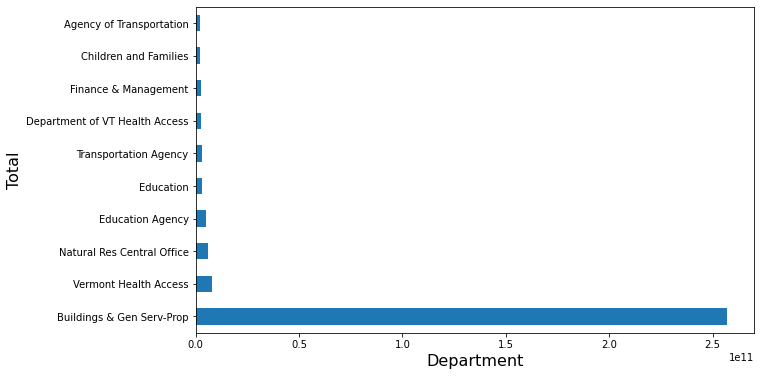

In [41]:
sql = """SELECT Department, SUM(Amount) as Total FROM VermontVendor 
GROUP BY Department
ORDER BY Total DESC
LIMIT 10"""

plot_df = spark.sql(sql).toPandas()

fig,ax = plt.subplots(1,1,figsize=(10,6))
plot_df.plot(x = 'Department', y = 'Total', kind = 'barh', color = 'C0', ax = ax, legend = False)
ax.set_xlabel('Department', size = 16)
ax.set_ylabel('Total', size = 16)
plt.savefig('barplot.png')
plt.show()

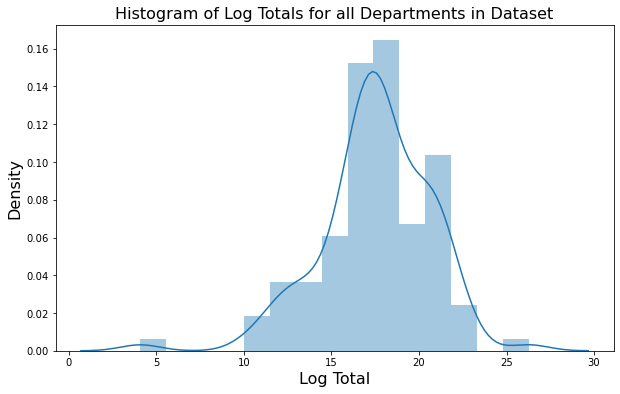

In [42]:
import numpy as np
import seaborn as sns

sql = """SELECT Department, SUM(Amount) as Total FROM VermontVendor 
GROUP BY Department"""

plot_df = spark.sql(sql).toPandas()

plt.figure(figsize = (10,6))
sns.distplot(np.log(plot_df['Total']))
plt.title('Histogram of Log Totals for all Departments in Dataset', size = 16)
plt.ylabel('Density', size = 16)
plt.xlabel('Log Total', size = 16)
plt.savefig('distplot.png')
plt.show()

In [43]:
sql = parametrize_sql_query("", "my_select", dict())
print(sql)

df = spark.sql(sql).limit(10)
df.show(truncate = False)

SELECT `Quarter Ending`, Department, Amount, State FROM VermontVendor
+--------------+---------------------------+------+-----+
|Quarter Ending|Department                 |Amount|State|
+--------------+---------------------------+------+-----+
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Environmental Conservation |930.0 |NY   |
|09/30/2009    |Vermont Veterans' Home     |24.0  |CT   |
|09/30/2009    |Vermont Veterans' Home     |420.0 |CT   |
|09/30/2009    |Corrections                |270.8 |PA   |
|09/30/2009    |Corrections                |35.0  |PA   |
|09/30/2009    |Public Safety              |971.4 |PA   |
|09/30/2009    |Agriculture, Food & Markets|60.59 |TX   |
|09/30/2009    |Agriculture, Food & Markets|541.62|TX   |
|09/30/2009    |Health                     |283.98|PA   |
+--------------+---------------------------+------+-----+



In [44]:
df.write.format('csv').option('header', True).mode('overwrite').option('sep',',').save('output.csv')